In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import cluster, datasets, metrics
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import DBSCAN, KMeans
import umap

plt.style.use("seaborn")

%matplotlib inline

# Business problem
* The goal is to develop customized marketing campaigns and they ask you to group customers based on the given information.

# Data
- We will use the [Credit Card Dataset for clustering](https://www.kaggle.com/arjunbhasin2013/ccdata) from Kaggle.


In [109]:
creditcard_df = pd.read_csv("../data/CC General.csv")
creditcard_df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# Information of the dataset 

We have behavioral data. 

- CUSTID: Identification of Credit Card holder
- BALANCE: Balance amount left in customer's account to make purchases
- BALANCE_FREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- PURCHASES: Amount of purchases made from account
- ONEOFFPURCHASES: Maximum purchase amount done in one-go
- INSTALLMENTS_PURCHASES: Amount of purchase done in installment
- CASH_ADVANCE: Cash in advance given by the user
- PURCHASES_FREQUENCY: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- ONEOFF_PURCHASES_FREQUENCY: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- PURCHASES_INSTALLMENTS_FREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- CASH_ADVANCE_FREQUENCY: How frequently the cash in advance being paid
- CASH_ADVANCE_TRX: Number of Transactions made with "Cash in Advance"
- PURCHASES_TRX: Number of purchase transactions made
- CREDIT_LIMIT: Limit of Credit Card for user
- PAYMENTS: Amount of Payment done by user
- MINIMUM_PAYMENTS: Minimum amount of payments made by user
- PRC_FULL_PAYMENT: Percent of full payment paid by user
- TENURE: Tenure of credit card service for user

# Preliminary EDA

In [110]:
creditcard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

* All numeric features
* Some missing values

In [111]:
creditcard_df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


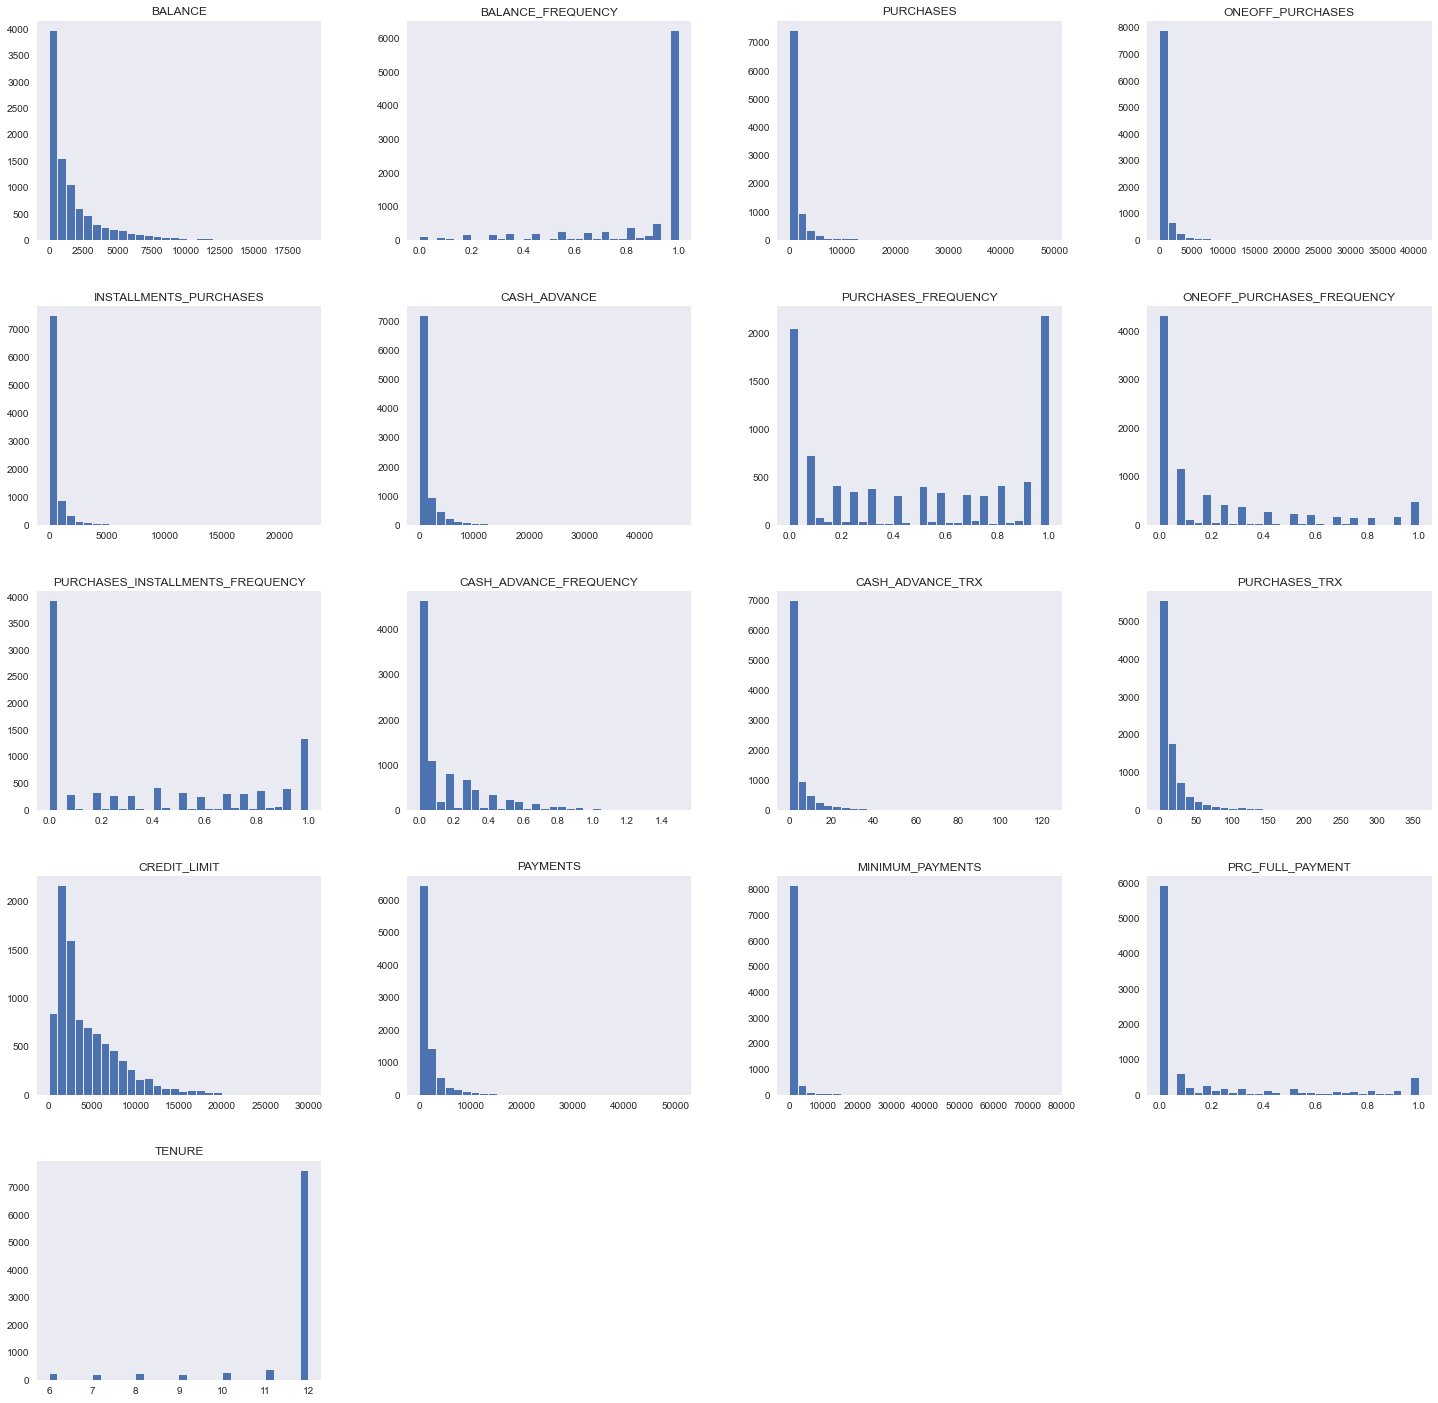

In [112]:
creditcard_df.hist(
    bins=30,
    figsize=(25, 25),
    grid = False,
    rwidth = 0.9,
)
plt.show()

* BALANCE - Balance left in the account is most frequent around 1,000 dollars.
* PURCHASES -  Puchase values concentrate below 5,000 dollars.
* BALANCE FREQUENCY — we can see that clients frequently update the balance in their accounts.
* ONEOFF_PURCHASES and INSTALLMENT_PURCHASES — looking at the scale of the graph we notice that purchases with installments are more frequent for values no greater than 5,000 dollars and one-off purchases are more frequent for values no greater than 10,000 dollars.
* PURCHASE FREQUENCY - This shows a segmentation of clients: one group make purchases very frequently, while the other group rarely make purchases.
* MINIMUM PAYMENTS and PRC FULL PAYMENT — these variables show us that many clients opt for paying the minimum of their credit card bill. Very few clients pay the full bill. This is also good for the bank as taxes are high for credit card bills.
* TENURE shows that most of the clients are long term clients (more than 11 years)

# Feature types and preprocessing 

Let's identify different feature types and transformations 

In [113]:
creditcard_df.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [114]:
drop_features = ["CUST_ID"]
numeric_features = list(set(creditcard_df.columns) - set(drop_features))

In [115]:
from sklearn.impute import SimpleImputer

numeric_transformer = make_pipeline(SimpleImputer(), StandardScaler())

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features), ("drop", drop_features)
)

In [116]:
transformed_df = pd.DataFrame(
    data=preprocessor.fit_transform(creditcard_df), columns=numeric_features
)

In [117]:
transformed_df

,CREDIT_LIMIT,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,ONEOFF_PURCHASES_FREQUENCY,PAYMENTS,MINIMUM_PAYMENTS,PURCHASES_FREQUENCY,CASH_ADVANCE_TRX,TENURE,PURCHASES_TRX,PURCHASES_INSTALLMENTS_FREQUENCY,INSTALLMENTS_PURCHASES,PRC_FULL_PAYMENT,BALANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE
0,-0.960433,-0.249434,-0.424900,-0.356934,-0.678661,-0.528979,-3.109675e-01,-0.806490,-0.476070,0.360680,-0.511333,-0.707313,-0.349079,-0.525551,-0.731989,-0.675349,-0.466786
1,0.688639,0.134325,-0.469552,-0.356934,-0.678661,0.818642,8.931021e-02,-1.221758,0.110074,0.360680,-0.591796,-0.916995,-0.454576,0.234227,0.786961,0.573963,2.605605
2,0.826062,0.518084,-0.107668,0.108889,2.673451,-0.383805,-1.016632e-01,1.269843,-0.476070,0.360680,-0.109020,-0.916995,-0.454576,-0.525551,0.447135,-0.675349,-0.466786
3,0.826062,-1.016953,0.232058,0.546189,-0.399319,-0.598688,4.878305e-17,-1.014125,-0.329534,0.360680,-0.551565,-0.916995,-0.454576,-0.525551,0.049099,-0.258913,-0.368653
4,-0.905464,0.518084,-0.462063,-0.347294,-0.399319,-0.364368,-2.657913e-01,-1.014125,-0.476070,0.360680,-0.551565,-0.916995,-0.454576,-0.525551,-0.358775,-0.675349,-0.466786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,-0.960433,0.518084,-0.333293,-0.356934,-0.678661,-0.486217,-3.498541e-01,1.269843,-0.476070,-4.122768,-0.350408,1.179833,-0.132643,1.183951,-0.737950,-0.675349,-0.466786
8946,-0.960433,0.518084,-0.329136,-0.356934,-0.678661,-0.503396,4.878305e-17,1.269843,-0.476070,-4.122768,-0.350408,1.179833,-0.122823,-0.525551,-0.742423,-0.675349,-0.466786
8947,-0.960433,-0.185477,-0.401965,-0.356934,-0.678661,-0.570615,-3.354655e-01,0.854576,-0.476070,-4.122768,-0.390639,0.760469,-0.294893,0.329200,-0.740398,-0.675349,-0.466786
8948,-1.097856,-0.185477,-0.469552,-0.356934,-0.678661,-0.580536,-3.469065e-01,-1.221758,-0.182998,-4.122768,-0.591796,-0.916995,-0.454576,0.329200,-0.745174,0.157527,-0.449352


Now that we have transformed the data, we are ready to run K-Means to cluster credit card customers. 

# Choosing `n_clusters`

### The Elbow method

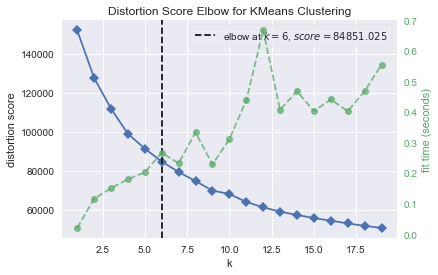

In [118]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(1, 20))

visualizer.fit(transformed_df)  # Fit the data to the visualizer
visualizer.show();

- The optimal number of clusters is not as clear as it was in our toy example. 

- Let's examine Silhouette scores.  

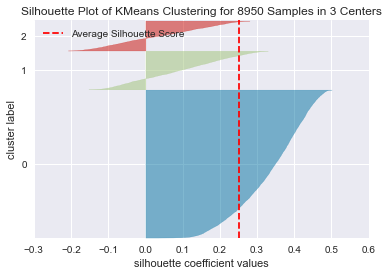

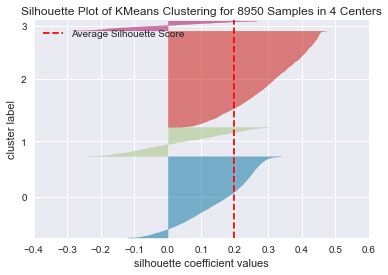

In [119]:
for k in range(3, 6):
    model = KMeans(k, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
    visualizer.fit(transformed_df)  # Fit the data to the visualizer
    visualizer.show()

- I'm going to run `KMeans` with `n_clusters = 4`. 


### Visualizing clusters 
 
- We have a high dimensional data and we need to reduce the dimensionality in order to visualize it. 
- Let's reduce the dimensionality using a technique called [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html). 

In [120]:
def plot_umap_clusters(
    data,
    cluster_labels,
    size=50,
    n_neighbors=15,
    title="UMAP visualization",
):
    """
    Carry out dimensionality reduction using UMAP and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    size : int
        size of points in the scatterplot
    n_neighbors : int
        n_neighbors hyperparameter of UMAP. See the documentation.
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    reducer = umap.UMAP(n_neighbors=n_neighbors)
    Z = reducer.fit_transform(data)  # reduce dimensionality
    umap_df = pd.DataFrame(data=Z, columns=["dim1", "dim2"])
    umap_df["cluster"] = cluster_labels

    labels = np.unique(umap_df["cluster"])

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(title)

    scatter = ax.scatter(
        umap_df["dim1"],
        umap_df["dim2"],
        c=umap_df["cluster"],
        cmap="tab20b",
        s=size,
        edgecolors="k",
        linewidths=0.1,
    )

    legend = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
    ax.add_artist(legend)

    plt.show()

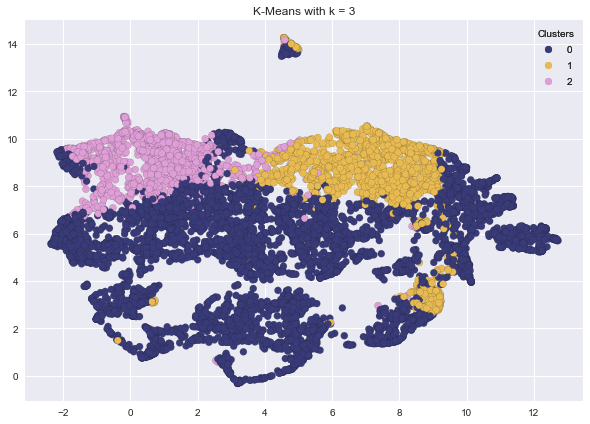

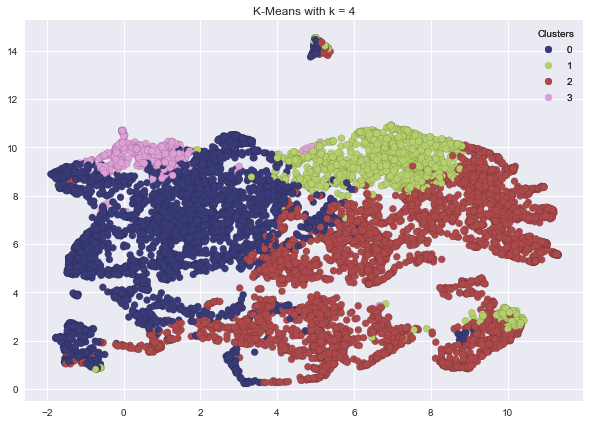

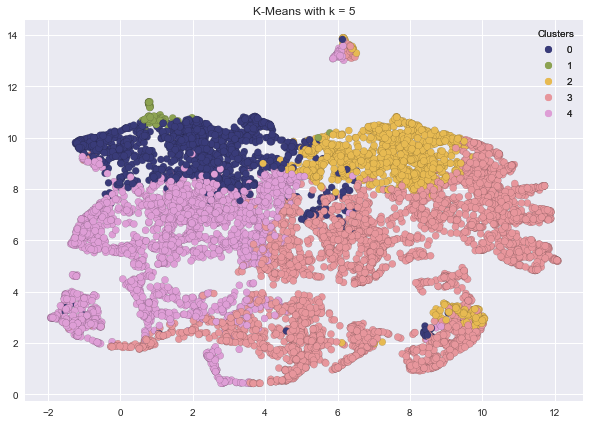

In [132]:
for k in range(3, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(transformed_df)
    labels = kmeans.labels_
    plot_umap_clusters(transformed_df, kmeans.labels_, title=f"K-Means with k = {k}")

- The 4 clusters above look reasonably well separated. 


# Cluster interpretation

- Let's examine the cluster centers for k=4 and identify types of customers.  

In [122]:
reasonable_k = 4
kmeans = KMeans(n_clusters=reasonable_k, random_state=42)
kmeans.fit(transformed_df)
labels = kmeans.labels_

In [123]:
cluster_centers = pd.DataFrame(
    data=kmeans.cluster_centers_, columns=[transformed_df.columns]
)
cluster_centers

,CREDIT_LIMIT,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,ONEOFF_PURCHASES_FREQUENCY,PAYMENTS,MINIMUM_PAYMENTS,PURCHASES_FREQUENCY,CASH_ADVANCE_TRX,TENURE,PURCHASES_TRX,PURCHASES_INSTALLMENTS_FREQUENCY,INSTALLMENTS_PURCHASES,PRC_FULL_PAYMENT,BALANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE
0,-0.077298,0.242574,0.109044,0.000926,0.317153,-0.138502,-0.091844,0.983721,-0.360303,0.057744,0.296985,0.874138,0.255904,0.395041,-0.321688,-0.462599,-0.366373
1,0.838968,0.384753,-0.234638,-0.163914,-0.212939,0.603821,0.490910,-0.504848,1.617143,-0.097146,-0.283580,-0.450201,-0.253747,-0.406367,1.459578,1.745948,1.688972
2,-0.334417,-0.368944,-0.343190,-0.230500,-0.389437,-0.262060,-0.119249,-0.797823,-0.164607,-0.052972,-0.474987,-0.714246,-0.387798,-0.258866,-0.265552,-0.101500,-0.182691
3,1.429882,0.462694,3.125845,2.713251,1.798653,1.919096,0.477421,1.136338,-0.170458,0.324140,3.003251,1.065918,2.406470,0.454703,0.954485,-0.319096,-0.155091


- Recall that we have applied imputation and scaling on the dataset. 
- But we would be able to interpret these clusters better if the centers are in the original scale. 
- So let's apply inverse transformations to get the cluster center values in the original scale. 

In [124]:
data = (
    preprocessor.named_transformers_["pipeline"]
    .named_steps["standardscaler"]
    .inverse_transform(cluster_centers[numeric_features])
)

In [125]:
org_cluster_centers = pd.DataFrame(data=data, columns=numeric_features)
org_cluster_centers = org_cluster_centers.reindex(
    sorted(org_cluster_centers.columns), axis=1
)
org_cluster_centers

,BALANCE,BALANCE_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,CREDIT_LIMIT,INSTALLMENTS_PURCHASES,MINIMUM_PAYMENTS,ONEOFF_PURCHASES,ONEOFF_PURCHASES_FREQUENCY,PAYMENTS,PRC_FULL_PAYMENT,PURCHASES,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,TENURE
0,894.907458,0.934734,210.570626,0.042573,0.790021,4213.207678,642.478274,650.167072,593.974874,0.297070,1332.194205,0.269258,1236.178934,0.885165,0.711842,22.091773,11.594595
1,4602.462714,0.968415,4520.724309,0.484526,14.284641,7546.957050,181.607404,2008.251157,320.373681,0.138934,3481.145990,0.034859,501.896219,0.287731,0.185516,7.661102,11.387312
2,1011.751528,0.789871,595.759339,0.114833,2.125503,3277.703165,60.386625,586.301239,209.853863,0.086281,974.505090,0.078001,269.973466,0.170146,0.080578,2.903421,11.446429
3,3551.153761,0.986879,653.638891,0.071290,2.085575,9696.943765,2587.208264,1976.815179,5095.878826,0.739031,7288.739497,0.286707,7681.620098,0.946418,0.788060,89.359413,11.951100


In [126]:
cluster_labels = {0: "Transactors", 1: "Revolvers", 2: "Low activity", 3: "VIP/Prime"}
org_cluster_centers["cluster_labels"] = list(cluster_labels.values())

In [127]:
relevant_cols = [
    "cluster_labels",
    "BALANCE",
    "CREDIT_LIMIT",
    "PRC_FULL_PAYMENT",
    "PURCHASES_FREQUENCY",
    "CASH_ADVANCE",
    "CASH_ADVANCE_FREQUENCY",
    "CASH_ADVANCE_TRX",
]
org_cluster_centers[relevant_cols]

,cluster_labels,BALANCE,CREDIT_LIMIT,PRC_FULL_PAYMENT,PURCHASES_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX
0,Transactors,894.907458,4213.207678,0.269258,0.885165,210.570626,0.042573,0.790021
1,Revolvers,4602.462714,7546.957050,0.034859,0.287731,4520.724309,0.484526,14.284641
2,Low activity,1011.751528,3277.703165,0.078001,0.170146,595.759339,0.114833,2.125503
3,VIP/Prime,3551.153761,9696.943765,0.286707,0.946418,653.638891,0.071290,2.085575


One way to interpret and label the clusters above is as follows. 

#### Transactors
- Credit card users who pay off their balance every month with least amount of interest charges. 
- They are careful with their money. 
- They have lowest balance and cash advance

#### Revolvers
- Credit card users who pay off only part of their monthly balance. They use credit card as a loan.  
- They have highest balance and cash advance, high cash advance frequency, low purchase frequency, high cash advance transactions, low percentage of full payment
- Their credit limit is also high. **(Lucrative group for banks)**

#### Low activity
- There is not much activity in the account. It has low balance and not many purchases. 
- Credit card users who have low credit limit.

#### VIP/Prime
- Credit card users who have high credit limit. 
- They have high one-off purchases frequency, high number of purchase transactions. 
- They have high balance but they also have higher percentage of full payment, similar to transactors
- Target for increase credit limit (and increase spending habits)

In [128]:
creditcard_df['cluster'] = labels

In [129]:
def show_hists(df=creditcard_df, cols=["BALANCE", "CASH_ADVANCE"]):
    for i in cols:
        plt.figure(figsize=(35, 5))
        for j in range(4):
            plt.subplot(1, 4, j + 1)
            cluster = df[df["cluster"] == j]
            cluster[i].hist(bins=20)
            plt.title(f"{i}    \nCluster: {cluster_labels[j]} ")

        plt.show()

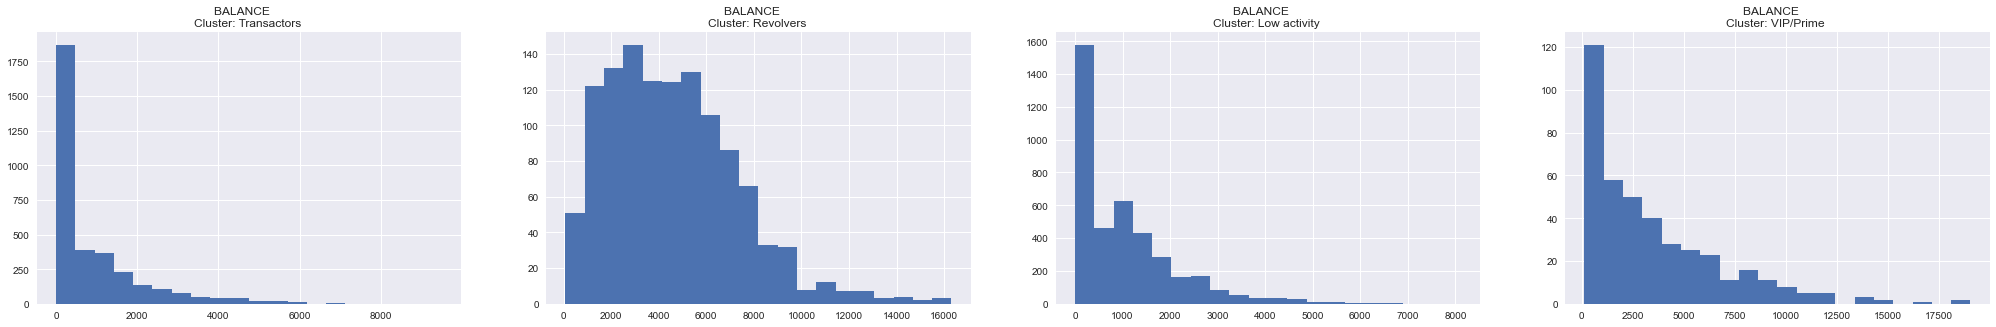

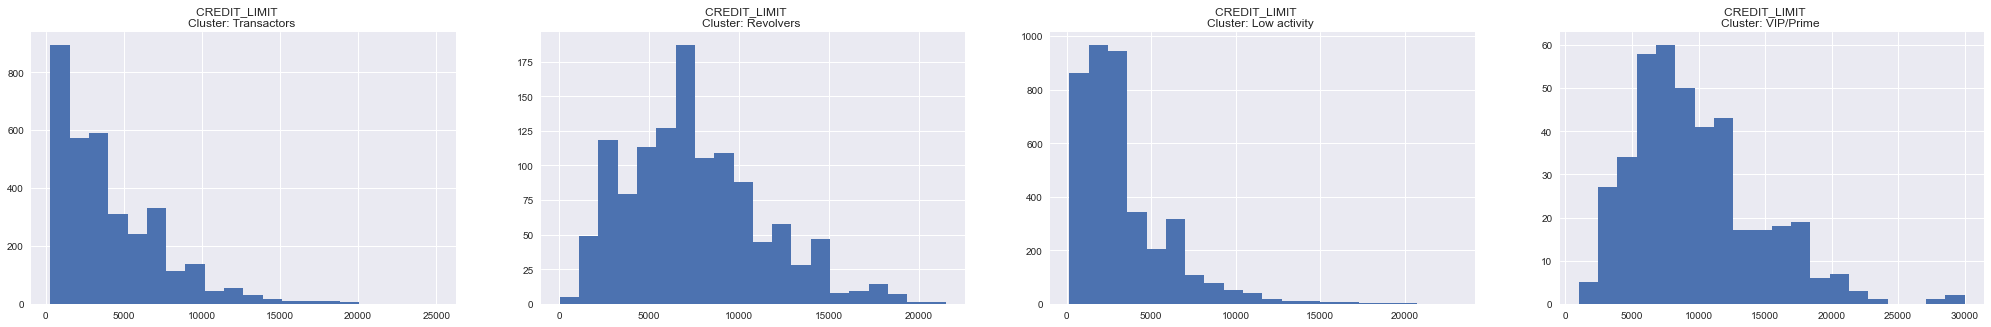

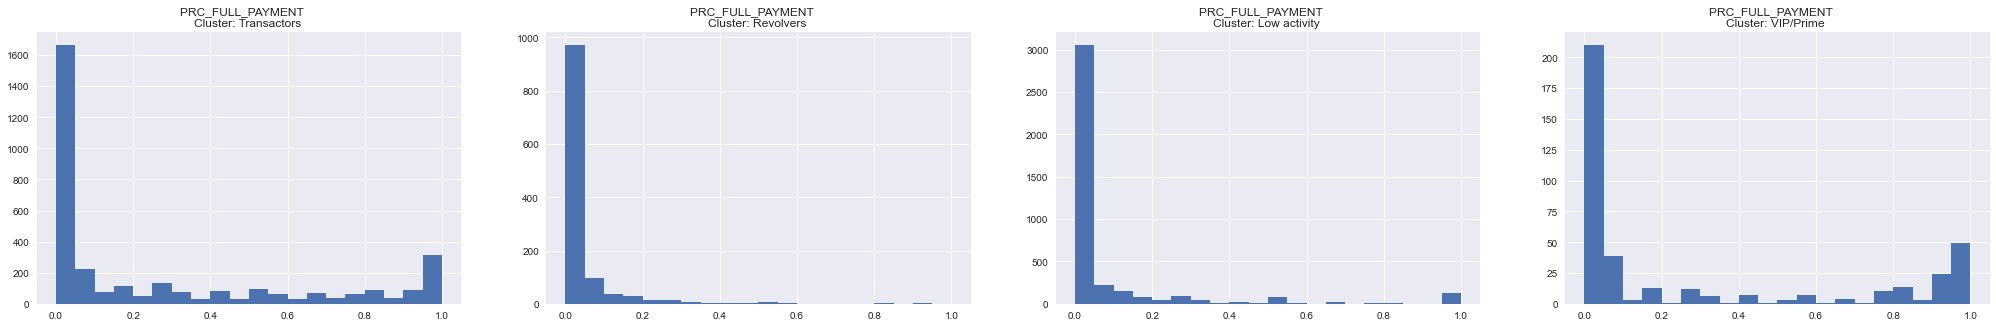

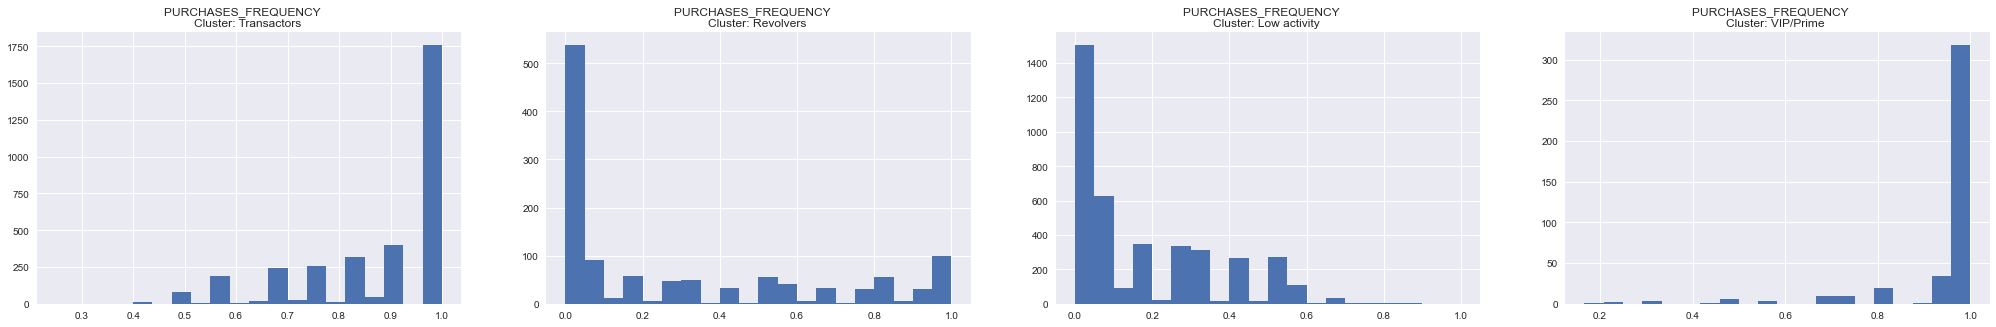

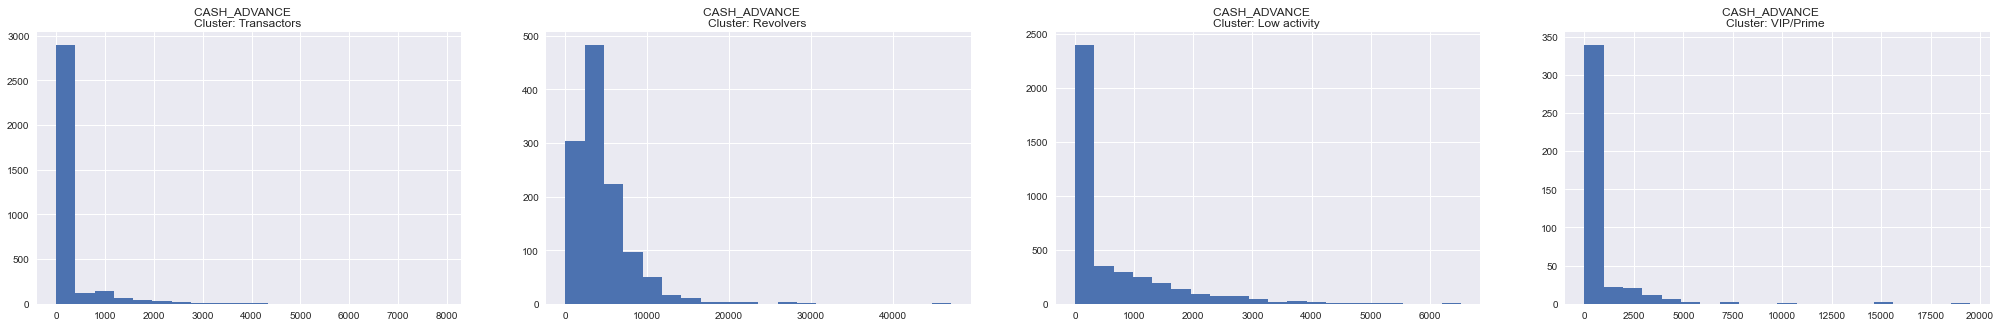

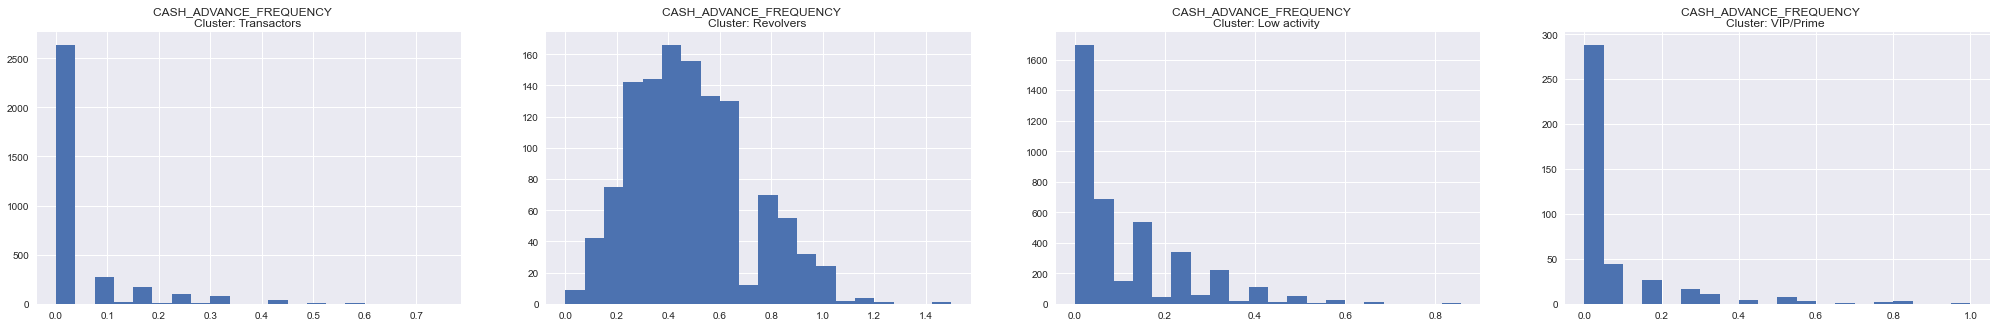

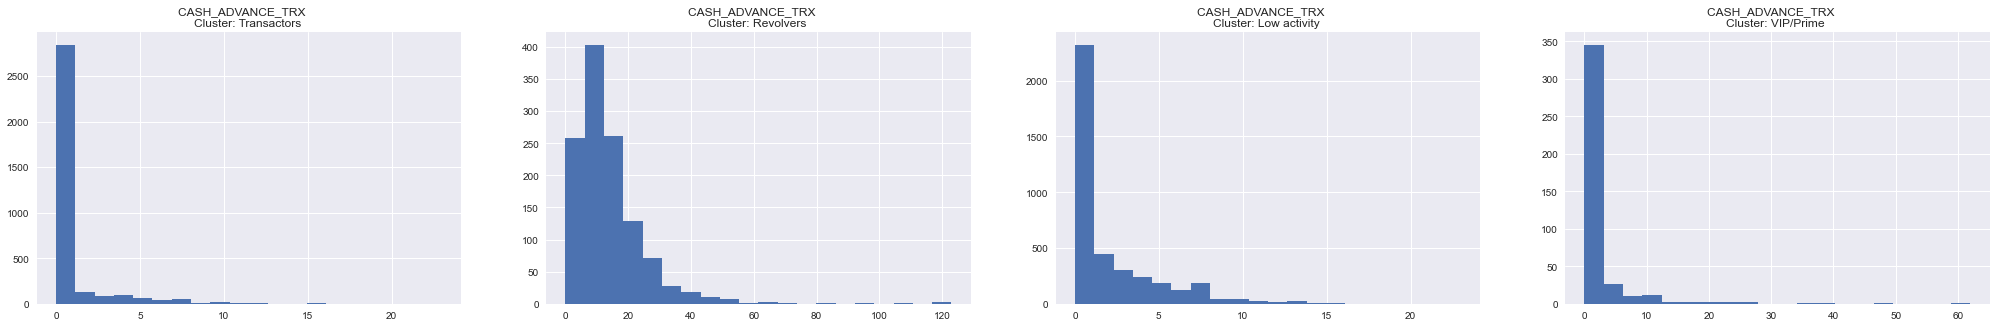

In [130]:
relevant_cols.remove('cluster_labels')
show_hists(creditcard_df, relevant_cols)